In [27]:
from sklearn.linear_model import LogisticRegression as lr
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import pandas  as pd
import numpy as np

In [16]:
DATASET_TO_USE = "PPI"

def get_ppi_dataset():
    # first row has the # of nodes and features
    emb_df = pd.read_csv(EMB_FILE, sep=" ", skiprows=1, header=None)
    emb_df.columns = ['node_id'] + [f"f{x}" for x in range(1, emb_df.shape[1])]

    lines = [line for line in open(INPUT_FILE).read().splitlines()]
    node_ids = [int(line.split()[0]) for line in lines]
    labels = [list(map(int, line.split()[1:])) for line in lines]
    input_df = pd.DataFrame({'node_id': node_ids, 'labels': labels})
    
    result_df = pd.merge(emb_df, input_df, on='node_id', how='inner')
    
    return result_df

def get_blog_dataset():
    # first row has the # of nodes and features
    emb_df = pd.read_csv(EMB_FILE, sep=" ", skiprows=1, header=None)
    emb_df.columns = ['node_id'] + [f"f{x}" for x in range(1, emb_df.shape[1])]

    input_df = pd.read_csv(INPUT_FILE, header=None, names=["node_id", "label"])
    input_df_grouped = input_df.groupby(by=['node_id'])['label'].apply(list).reset_index(name ='labels')
    result_df = pd.merge(emb_df, input_df_grouped, on='node_id', how='inner')
    
    return result_df


if "PPI":
    EMB_FILE = "../emb/ppi.emb"
    INPUT_FILE = "../data/PPI/ppi_labels.txt"
    df = get_ppi_dataset()
else:
    EMB_FILE = "../emb/seed_1_perc_0.5_blog_catalog.emb"
    INPUT_FILE = "../data/BlogCatalog/group-edges.csv"
    df = get_dataset()

In [25]:
# Extend prediction function for the OVR logistic regression model
class TopKRanker(OneVsRestClassifier):
    def predict(self, X, top_k_list):
        """
        return the labels with the highest k probabilities prediction, where k is the number of labels Y_test have
        """
        probs = np.asarray(super(TopKRanker, self).predict_proba(X))
        all_labels = []
        for i, k in enumerate(top_k_list):
            probs_ = probs[i, :]
            labels = self.classes_[probs_.argsort()[-k:]].tolist()
            probs_[:] = 0
            probs_[labels] = 1
            all_labels.append(probs_)
        return np.asarray(all_labels)

In [28]:

# test and train datasets are equal
test_perc_list =  [x/10 for x in range(1, 10)]


evaluations_micro = []
evaluations_macro = []
num_iter = 10

Y = df['labels']
X = df.drop(columns=['labels', 'node_id'])

# binarize data
binarizer = MultiLabelBinarizer()
binarizer.fit(Y)

lr =  OneVsRestClassifier(lr(solver='liblinear'))
clf = TopKRanker(lr)

for perc in test_perc_list:
    eva_micro = []
    eva_macro = []
    for x in range(num_iter):

        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=perc)

        Y_train = binarizer.transform(Y_train)

        Y_test_b = binarizer.transform(Y_test)

        # evaluation
        clf.fit(X_train, Y_train)
        top_k_list = [len(l) for l in Y_test]
        Y_pred = clf.predict(X_test, top_k_list=top_k_list)

        eva_micro.append(f1_score(Y_test_b, Y_pred, average='micro', zero_division=0))
        eva_macro.append(f1_score(Y_test_b, Y_pred, average='macro', zero_division=0))
        
    evaluations_micro.append((perc, sum(eva_micro)/num_iter*100),)
    evaluations_macro.append((perc, sum(eva_macro)/num_iter*100))
    print(f"Perc: {perc}")

/home/yasser/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/yasser/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/yasser/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Perc: 0.1
Perc: 0.2
Perc: 0.3
Perc: 0.4
Perc: 0.5
Perc: 0.6
Perc: 0.7
Perc: 0.8


/home/yasser/.local/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 11 is present in all training examples.
  warnings.warn(
/home/yasser/.local/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 49 is present in all training examples.
  warnings.warn(
/home/yasser/.local/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 44 is present in all training examples.
  warnings.warn(


Perc: 0.9


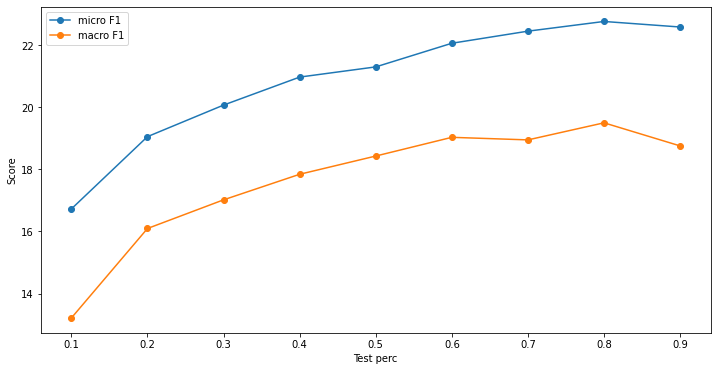

In [53]:
def plot_scores(micro, macro):
    fig, ax = plt.subplots(figsize=(12, 6))

    perc = [x[0] for x in micro]
    micro_score = [x[1] for x in micro]
    macro_score = [x[1] for x in macro]
    micro_score.reverse()
    macro_score.reverse()
    
    plt.plot(perc, micro_score, marker='o', label='Micro F1')
    
    plt.plot(perc, macro_score, marker='o', label='Macro F1')
        
        
    
    plt.xlabel("Test perc")
    plt.ylabel("Score")
    plt.legend(loc='best')
    plt.show()
    
plot_scores(evaluations_micro, evaluations_macro)